## 1) Library & Data Import

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")

In [0]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


#### Feature Description
- rating : 이용자 리뷰의 평가 점수
- text : 이용자 리뷰 평가 내용

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [0]:
df.shape

(1001, 2)

In [0]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
rating    1001 non-null int64
text      1001 non-null object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [0]:
df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [0]:
len(df['text'].values.sum())

223576

-----

## 3) 한국어 텍스트 데이터 전처리

### 3-0) konlpy 설치

In [0]:
# konlpy 0.5.2의 JVM 버그로 인해, 0.5.1 버전으로 install
!pip install konlpy==0.5.1 jpype1 Jpype1-py3

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 2.4MB 22.6MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
  Created wheel for Jpype1-py3: filename=JPype1_py3-0.5.5.4-cp36-cp36m-linux_x86_64.whl size=2674980 sha256=944b0879032ff6150b2a74ac7dbfc5ea7a1ca3a2cdb06aca9857f195d8e55c14
  Stored in directory: /root/.cache/pip/wheels/52/37/1f/1015d908d12a0e9b239543d031fda0cded9823aa1306939541
Successfully built Jpype1-py3


### 3-1) 정규표현식 적용

In [0]:
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [0]:
apply_regular_expression(df['text'][0])

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

-----

### 3-2) 한국어 형태소분석 - 명사 단위

##### 명사 형태소 추출

In [0]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(apply_regular_expression(df['text'][0]))

In [0]:
nouns

['여행', '집중', '휴식', '제공', '호텔', '위치', '선정', '또한', '청소', '청결', '상태']

In [0]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['text'].tolist())))

In [0]:
# 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('호텔', 803),
 ('수', 498),
 ('것', 436),
 ('방', 330),
 ('위치', 328),
 ('우리', 327),
 ('곳', 320),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264)]

##### 한글자 명사 제거

In [0]:
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('호텔', 803),
 ('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 192)]

-----

### 3-3) 불용어 사전

In [0]:
# source - https://www.ranks.nl/stopwords/korean
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
print(stopwords[:10])

[['휴'], ['아이구'], ['아이쿠'], ['아이고'], ['어'], ['나'], ['우리'], ['저희'], ['따라'], ['의해']]


In [0]:
# 데이터 특징을 반영한 불용어 추가
jeju_hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for word in jeju_hotel_stopwords:
    stopwords.append(word)

-----

### 3-4) Word Count

##### BoW 벡터 생성

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    tagger = Okt()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [0]:
word_list

['가가',
 '가게',
 '가격',
 '가격표',
 '가구',
 '가급',
 '가기',
 '가까이',
 '가끔',
 '가능',
 '가도',
 '가동',
 '가두',
 '가득',
 '가든',
 '가라',
 '가량',
 '가려움',
 '가로',
 '가면',
 '가몬',
 '가무',
 '가물',
 '가미',
 '가방',
 '가버',
 '가성',
 '가세',
 '가스레인지',
 '가스렌지',
 '가슴',
 '가시',
 '가신',
 '가야',
 '가옥',
 '가요',
 '가용',
 '가운데',
 '가을',
 '가인',
 '가장',
 '가정',
 '가정식',
 '가족',
 '가지',
 '가짓수',
 '가차',
 '가치',
 '가품',
 '각각',
 '각오',
 '각자',
 '각종',
 '각층',
 '간격',
 '간곳',
 '간다',
 '간단',
 '간만',
 '간식',
 '간이',
 '간주',
 '간직',
 '간판',
 '간혹',
 '갈껄',
 '갈비',
 '갈비탕',
 '갈수',
 '갈수록',
 '감각',
 '감동',
 '감명',
 '감사',
 '감상',
 '감소',
 '감안',
 '감자',
 '감히',
 '갑인',
 '갑자기',
 '갑작스레',
 '강남',
 '강력',
 '강아지',
 '강압',
 '강제',
 '강조',
 '강추',
 '개념',
 '개략',
 '개미',
 '개발',
 '개방',
 '개별',
 '개보',
 '개뿔',
 '개선',
 '개수대',
 '개월',
 '개인',
 '개인실',
 '개인정보',
 '개조',
 '개층',
 '객수',
 '객실',
 '갤러리',
 '갱스터',
 '거기',
 '거나',
 '거두',
 '거론',
 '거르세',
 '거름',
 '거리',
 '거린데',
 '거림',
 '거문도',
 '거미',
 '거부',
 '거실',
 '거여',
 '거울',
 '거위',
 '거의',
 '거절',
 '거주',
 '거지',
 '거참',
 '거품',
 '걱정',
 '건가',
 '건강',
 '건너',
 '건너편',
 '건물',
 '건의',
 '건조',


In [0]:
count_list

array([  4,   8, 245, ...,   1,   7,  14])

In [0]:
bow_vect.shape

(1001, 3599)

In [0]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
bow_vect.toarray().sum(axis=0)

array([  4,   8, 245, ...,   1,   7,  14])

In [0]:
bow_vect.toarray().sum(axis=0).shape

(3599,)

In [0]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가가': 4,
 '가게': 8,
 '가격': 245,
 '가격표': 1,
 '가구': 8,
 '가급': 1,
 '가기': 20,
 '가까이': 20,
 '가끔': 5,
 '가능': 10,
 '가도': 7,
 '가동': 2,
 '가두': 1,
 '가득': 2,
 '가든': 1,
 '가라': 3,
 '가량': 1,
 '가려움': 1,
 '가로': 2,
 '가면': 14,
 '가몬': 1,
 '가무': 1,
 '가물': 1,
 '가미': 1,
 '가방': 4,
 '가버': 1,
 '가성': 49,
 '가세': 3,
 '가스레인지': 1,
 '가스렌지': 1,
 '가슴': 1,
 '가시': 4,
 '가신': 3,
 '가야': 10,
 '가옥': 1,
 '가요': 5,
 '가용': 1,
 '가운데': 3,
 '가을': 4,
 '가인': 1,
 '가장': 42,
 '가정': 4,
 '가정식': 2,
 '가족': 94,
 '가지': 55,
 '가짓수': 3,
 '가차': 1,
 '가치': 15,
 '가품': 1,
 '각각': 7,
 '각오': 1,
 '각자': 2,
 '각종': 3,
 '각층': 1,
 '간격': 2,
 '간곳': 1,
 '간다': 4,
 '간단': 1,
 '간만': 1,
 '간식': 5,
 '간이': 3,
 '간주': 1,
 '간직': 1,
 '간판': 2,
 '간혹': 1,
 '갈껄': 1,
 '갈비': 1,
 '갈비탕': 1,
 '갈수': 7,
 '갈수록': 1,
 '감각': 1,
 '감동': 12,
 '감명': 1,
 '감사': 6,
 '감상': 3,
 '감소': 1,
 '감안': 5,
 '감자': 1,
 '감히': 1,
 '갑인': 1,
 '갑자기': 4,
 '갑작스레': 1,
 '강남': 1,
 '강력': 9,
 '강아지': 7,
 '강압': 2,
 '강제': 1,
 '강조': 1,
 '강추': 8,
 '개념': 1,
 '개략': 1,
 '개미': 1,
 '개발': 3,
 '개방': 2,
 '개별': 3,
 '개보': 1,
 '개뿔': 1,


-----

### 3-5) TF-IDF 적용

##### TF-IDF 변환

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [0]:
print(tf_idf_vect.shape)
print(tf_idf_vect[0])

(1001, 3599)
  (0, 3588)	0.35673213299026796
  (0, 2927)	0.2582351368959594
  (0, 2925)	0.320251680858207
  (0, 2866)	0.48843555212083145
  (0, 2696)	0.23004450213863206
  (0, 2311)	0.15421663035331626
  (0, 1584)	0.48843555212083145
  (0, 1527)	0.2928089229786031
  (0, 790)	0.2528176728459411


##### 벡터 : 단어 맵핑

In [0]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{2866: '집중', 3588: '휴식', 2696: '제공', 2311: '위치', 1584: '선정', 790: '또한', 2927: '청소', 2925: '청결', 1527..


-----

## 4) Logistic Regression 분류

### 4-1) 데이터셋 생성

##### Rating 데이터 이진으로 변환

In [0]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


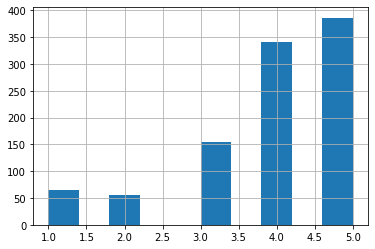

In [0]:
df.rating.hist()

In [0]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

df['y'] = df['rating'].apply(lambda x: rating_to_label(x))

In [0]:
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [0]:
df.y.value_counts()

1    726
0    275
Name: y, dtype: int64

-----

### 4-2) 데이터셋 분리

In [0]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.30)

In [0]:
print(x_train.shape)
print(x_test.shape)

(700, 3599)
(301, 3599)


-----

### 4-3) 모델 학습

##### Logistic Regression 학습

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train LR model
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# classifiacation predict
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [0]:
# classification result for test dataset
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.72
Precision : 0.718
Recall : 1.000
F1 : 0.836


In [0]:
from sklearn.metrics import confusion_matrix

# print confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  3  84]
 [  0 214]]


-----

### 4-4) 샘플링 재조정

##### 1:1 Sampling

In [0]:
positive_random_idx = df[df['y']==1].sample(275, random_state=33).index.tolist()
negative_random_idx = df[df['y']==0].sample(275, random_state=33).index.tolist()

In [0]:
# dataset split to train/test
random_idx = positive_random_idx + negative_random_idx
X = tf_idf_vect[random_idx]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [0]:
print(x_train.shape)
print(x_test.shape)

(412, 3599)
(138, 3599)


##### 모델 재학습

In [0]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [0]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.72
Precision : 0.644
Recall : 0.797
F1 : 0.712


In [0]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[53 26]
 [12 47]]


-----

## 5) 긍정/부정 키워드 분석

##### Logistic Regression 모델의 coef 분석

<BarContainer object of 3599 artists>

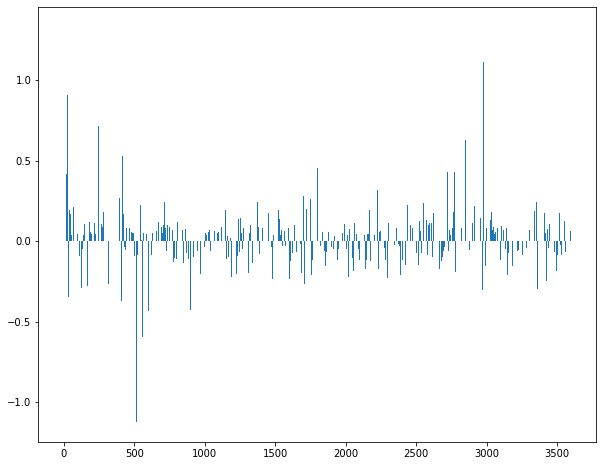

In [0]:
# print logistic regression's coef
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

##### 긍정/부정 키워드 출력

In [0]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.3321308087111168, 2400), (1.1098677278465363, 2977), (1.029120247844704, 1247), (0.9474432432978868, 2957), (0.9049132254229898, 26)]
[(-0.6491883332225628, 363), (-0.6683241824194205, 3538), (-0.6811855513119685, 1909), (-0.9632209931825515, 1293), (-1.124500886987929, 515)]


In [0]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_index

[(1.3321308087111168, 2400),
 (1.1098677278465363, 2977),
 (1.029120247844704, 1247),
 (0.9474432432978868, 2957),
 (0.9049132254229898, 26),
 (0.8631251640260484, 385),
 (0.8624237330200107, 2730),
 (0.7848182816732695, 578),
 (0.732990219026413, 2311),
 (0.716865493140725, 246),
 (0.7161355390234533, 1809),
 (0.7134163462461057, 956),
 (0.7044600617626677, 115),
 (0.6869152801231841, 1384),
 (0.6556108465327279, 1148),
 (0.6279495890384094, 2849),
 (0.6222266165132151, 2779),
 (0.6161464320403829, 883),
 (0.5993549427526994, 1491),
 (0.5957963623120057, 2680),
 (0.5486926383676386, 2834),
 (0.5396380473836403, 660),
 (0.5293505033175993, 416),
 (0.5268251635528765, 680),
 (0.5162996339456437, 3447),
 (0.515397298688398, 2781),
 (0.5102891400815143, 790),
 (0.5001491197806007, 3428),
 (0.4929472812035707, 1816),
 (0.49144456248364404, 692),
 (0.48756380000669713, 131),
 (0.48684210942709405, 1159),
 (0.45674587837763275, 1217),
 (0.45540907417568605, 1853),
 (0.4539368892907782, 981),

In [0]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

In [0]:
for coef in coef_pos_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

이용 1.3321308087111168
추천 1.1098677278465363
버스 1.029120247844704
최고 0.9474432432978868
가성 0.9049132254229898
근처 0.8631251640260484
조식 0.8624237330200107
다음 0.7848182816732695
위치 0.732990219026413
공간 0.716865493140725
시설 0.7161355390234533
맛집 0.7134163462461057
거리 0.7044600617626677
분위기 0.6869152801231841
바다 0.6556108465327279


In [0]:
for coef in coef_neg_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.124500886987929
별로 -0.9632209931825515
아무 -0.6811855513119685
화장실 -0.6683241824194205
그냥 -0.6491883332225628
모기 -0.6302873381425533
수건 -0.6243491941007028
느낌 -0.5975494080979522
모텔 -0.5971174361320487
다른 -0.5966138818945081
최악 -0.593317479621261
음식 -0.5443424935120069
주위 -0.5321043465183405
진짜 -0.5254380815734122
목욕 -0.5087212885846032
